# Transfer with Resnet-18

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision.datasets import CIFAR10, CIFAR100, MNIST, FashionMNIST
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.autograd import Variable
import torch.optim as optim
from random import shuffle


class GrayscaleToRGB(object):

    def __call__(self, img):

        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)

        return img

    def __repr__(self):
        return self.__class__.__name__ + '()'

def get_dataloaders(dataset):

    transform = transforms.Compose([
        transforms.ToTensor(),
        GrayscaleToRGB(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = dataset(root='./data', train=True,
                       download=True, transform=transform)

    nb_classes = len(trainset.classes)

    nb_train = len(trainset)
    nb_val = int(0.1 * nb_train)

    idx = list(range(nb_train))
    shuffle(idx)

    valset = Subset(trainset, idx[:nb_val])
    trainset = Subset(trainset, idx[nb_val:])

    nb_batch = 128

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=nb_batch,
                                              shuffle=True, num_workers=4)
    valloader = torch.utils.data.DataLoader(valset, batch_size=nb_batch,
                                            shuffle=True, num_workers=4)

    testset = dataset(root='./data', train=False,
                      download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=nb_batch,
                                             shuffle=False, num_workers=4)

    return trainloader, valloader, testloader, nb_classes

def train_and_test(dataset, scale_input, fine_tune):

    trainloader, valloader, testloader, nb_classes = get_dataloaders(dataset)
    nb_epochs = 3 if nb_classes <= 10 else 10

    # initialise network
    net = models.resnet18(pretrained=True)

    if not fine_tune:  # freeze feature extraction layers
        for param in net.parameters():
            param.requires_grad = False

    num_ftrs = 512

    net.fc = nn.Linear(num_ftrs, nb_classes)
    net.to(device)

    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                          lr=0.001, momentum=0.9)

    train_losses, val_losses = [], []

    for epoch in range(nb_epochs):

        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = scale_input(inputs)
            inputs, labels = inputs.to(device), Variable(labels.to(device))

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                train_losses.append(running_loss / 100)
                running_loss = 0.0

    correct, total = 0, 0

    net.eval()

    for data in testloader:
        images, labels = data
        outputs = net(scale_input(Variable(images.to(device))))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels.to(device)).sum()

    accuracy = (100 * correct / total).item()

    return train_losses, accuracy

def run_and_plot(dataset, input_size)

    scales = [1, 2, 4, 8]
    df_line_data, df_bar_data = pd.DataFrame(), pd.DataFrame()

    for fine_tune in [True, False]:

        df_line, df_bar = pd.DataFrame(), pd.DataFrame()
        accuracies = []

        for idx, scale_factor in enumerate(scales):

            scale_input = nn.Upsample(scale_factor=scale_factor)
            train_losses, accuracy = train_and_test(dataset,
                                                    scale_input,
                                                    fine_tune=fine_tune)
            input_resize = scale_factor * input_size
            df_line['%dx%d' % (input_resize, input_resize)] = train_losses
            accuracies.append(accuracy)

        df_line['Iteration'] = np.arange(len(train_losses))
        df_line['Transfer'] = 'Fine-tuned' if fine_tune else 'Frozen'

        df_bar['Scale'] = ['%dx%d' % (x, x) for x in input_size * np.array(scales)]
        df_bar['Accuracy'] = accuracies
        df_bar['Transfer'] = 'Fine-tuned' if fine_tune else 'Frozen'

        df_line_data = pd.concat([df_line_data, df_line])
        df_bar_data = pd.concat([df_bar_data, df_bar])

    df_line_data = pd.melt(df_line_data, id_vars=['Iteration', 'Transfer'],
                           value_name='Train loss', var_name='Scale')

    fig, axes = plt.subplots(figsize=(10, 8), ncols=2)
    sns.lineplot(data=df_line_data, x='Iteration', y='Train loss', hue='Scale', style='Transfer',
                 palette=sns.color_palette('pastel')[:len(scales)], ax=axes[0])
    sns.barplot(x='Transfer', y='Accuracy', hue='Scale', data=df_bar_data, ax=axes[1],
                palette=sns.color_palette('pastel'), ci=None)
    plt.tight_layout()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

## CIFAR10

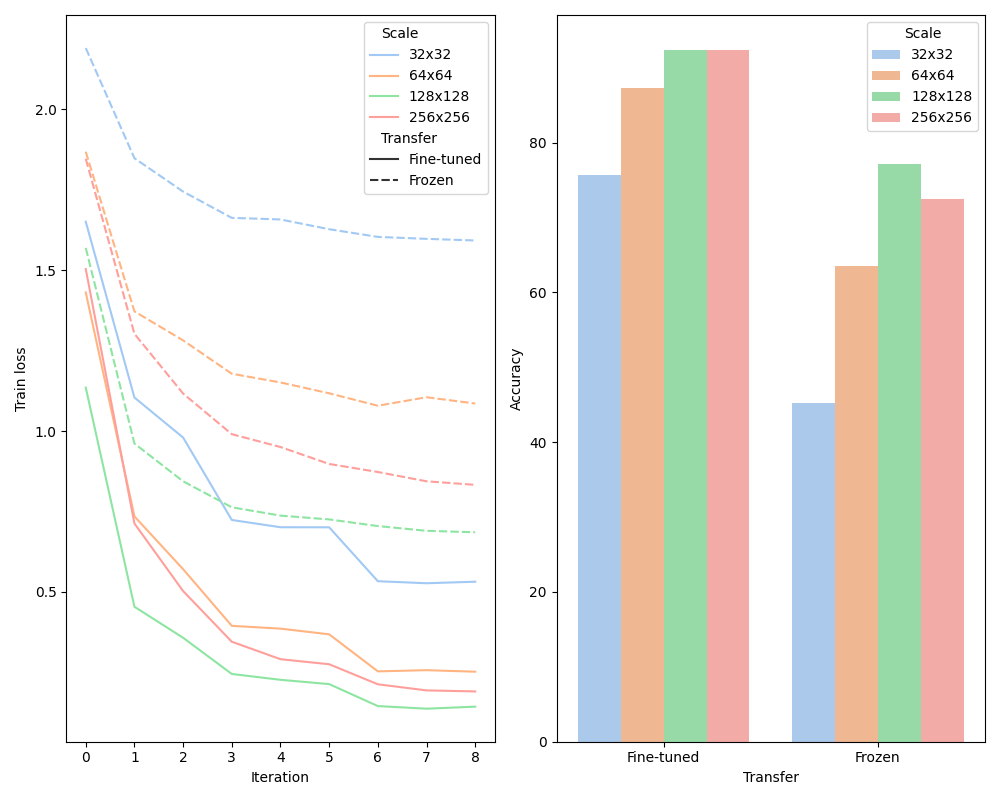

In [2]:
run_and_plot(CIFAR10, 32)

## CIFAR100

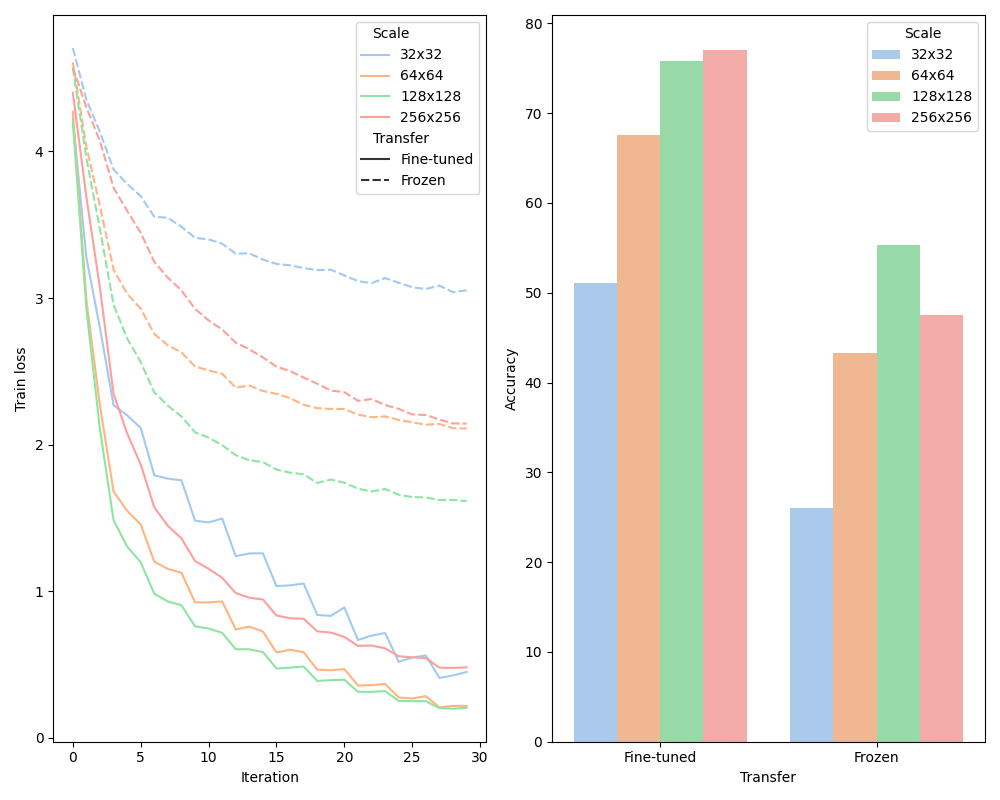

In [3]:
run_and_plot(CIFAR100, 32)

## MNIST

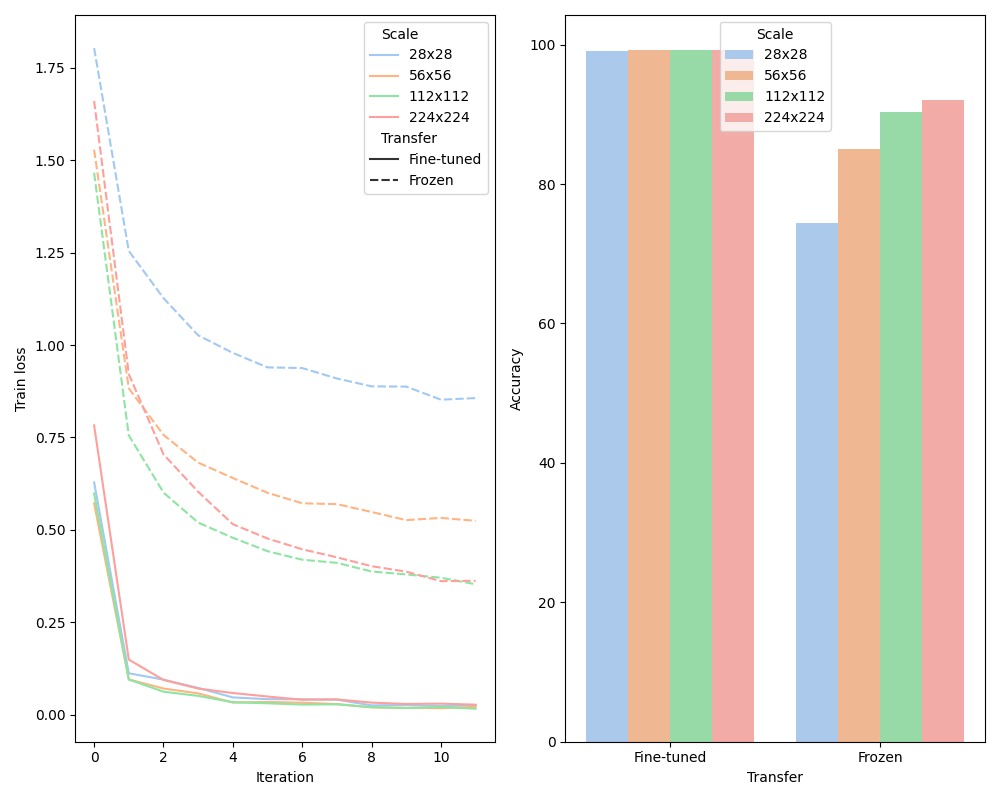

In [4]:
run_and_plot(MNIST, 28)

## Fasion-MNIST

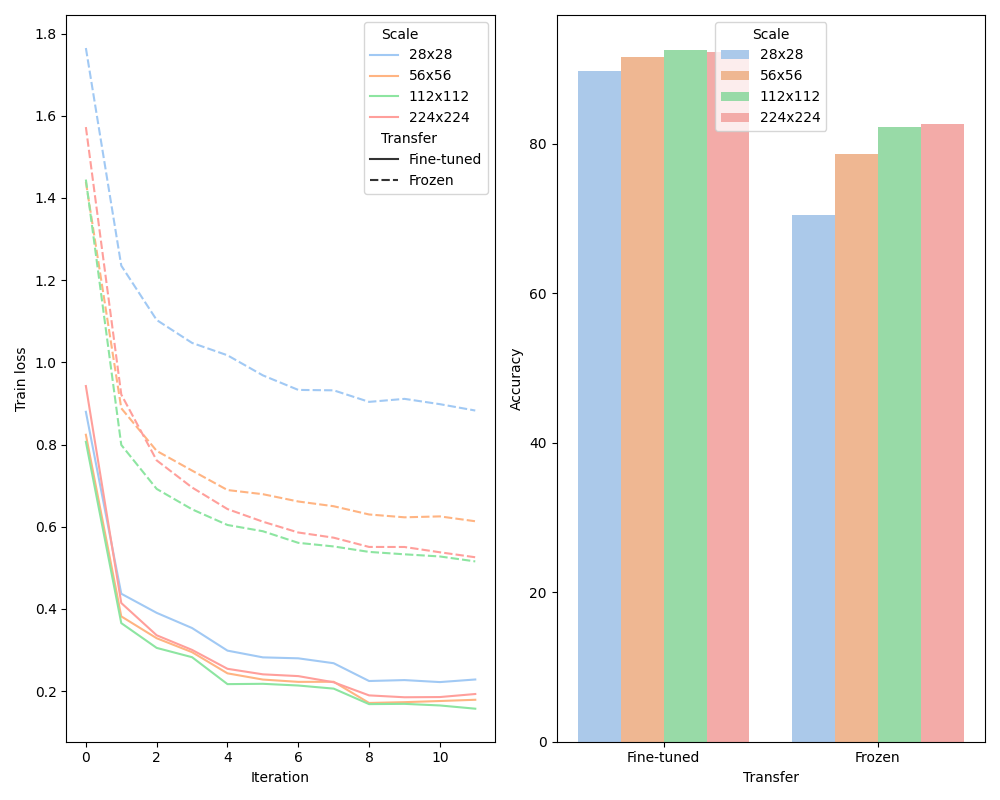

In [5]:
run_and_plot(FashionMNIST, 28)